In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

from scipy.stats import uniform, randint
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

/Users/cary/.local/share/virtualenvs/cs7cs4-group-comp-PCvzJ4oH/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# import data
# training data, data in some columns (2,4) is mix-typed so use unicode
# explicitly assign types to columns
t_df = pd.read_csv('source_data/train.csv', index_col=[0], dtype={
    'Housing Situation': 'unicode',
    'Work Experience in Current Job [years]': 'unicode'
})

p_df = pd.read_csv('source_data/predict.csv', index_col=[0], dtype={
    'Housing Situation': 'unicode',
    'Work Experience in Current Job [years]': 'unicode'
})

t_df.head()

/Users/cary/.local/share/virtualenvs/cs7cs4-group-comp-PCvzJ4oH/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Year of Record,Housing Situation,Crime Level in the City of Employement,Work Experience in Current Job [years],Satisfation with employer,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Yearly Income in addition to Salary (e.g. Rental Income),Total Yearly Income [EUR]
Instance,,,,,,,,,,,,,,,,
1,1940.0,0,33,17,Unhappy,other,45,Afghanistan,25179,group head,No,1,Black,182,0 EUR,6182.05
2,1940.0,0,25,4.9,Unhappy,female,17,Afghanistan,2278204,heavy vehicle and mobile equipment service tec...,No,0,Blond,172,0 EUR,6819.69
3,1940.0,0,34,21,Unhappy,female,48,Afghanistan,822134,sorter,Bachelor,0,Blond,144,0 EUR,8663.53
4,1940.0,0,70,18,Average,female,42,Albania,59477,quality control senior engineer,No,1,Brown,152,0 EUR,2400.64
5,1940.0,0,51,8,Happy,other,15,Albania,23494,logistician,Master,1,Black,180,0 EUR,2816.18


In [3]:
rename_map = {
    'Year of Record': 'Year',
    'Housing Situation': 'Housing',
    'Crime Level in the City of Employement': 'Crime',
    'Work Experience in Current Job [years]': 'WorkExp',
    'Satisfation with employer': 'Satisfation',
    'Size of City': 'SoC',
    'University Degree': 'UD',
    'Wears Glasses': 'Glasses',
    'Body Height [cm]': 'Height',
    'Yearly Income in addition to Salary (e.g. Rental Income)': 'AddIn',
    'Total Yearly Income [EUR]': 'Income'
}

t_df.rename(columns=rename_map, inplace=True)
p_df.rename(columns=rename_map, inplace=True)

In [4]:
# see N/A values in train data
t_df.shape[0] - t_df.count()

Year            4013
Housing            0
Crime              0
WorkExp            0
Satisfation    38087
Gender         74127
Age                0
Country            0
SoC                0
Profession      2853
UD             80600
Glasses            0
Hair Color     70211
Height             0
AddIn              0
Income             0
dtype: int64

In [5]:
# see N/A values in predict data
p_df.shape[0] - p_df.count()

Year             1494
Housing             0
Crime               0
WorkExp             0
Satisfation     13432
Gender          26308
Age                 0
Country             1
SoC                 0
Profession       1041
UD              28738
Glasses             0
Hair Color      24651
Height              0
AddIn               0
Income         369438
dtype: int64

In [6]:
# training data preprocessing before concat with predict data

# drop duplicates
t_df = t_df.drop_duplicates()

# drop (t_df['Year'] < 2000) & (t_df['Income'] > 400000)
t_df.drop(t_df[(t_df['Year'] < 2000) & (t_df['Income'] > 400000)].index, inplace=True)

# drop Income > 1000000
t_df.drop(t_df[t_df['Income'] > 1000000].index, inplace=True)

# drop Crime >= 200
t_df.drop(t_df[t_df['Crime'] >= 200].index, inplace=True)

# drop Age >= 110
t_df.drop(t_df[t_df['Age'] >= 110].index, inplace=True)

# drop Country '0'
t_df.drop(t_df[t_df['Country'] == '0'].index, inplace=True)

# rid of N/A or invalid rows for a column (small amount of them)
t_df.dropna(subset = ['Year'], inplace=True)
t_df.dropna(subset = ['Profession'], inplace=True)
t_df.drop(t_df[t_df['WorkExp'] == '#NUM!'].index, inplace=True)
t_df.drop(t_df[t_df['Gender'] == '0'].index, inplace=True)

In [7]:
# after deletion in on train data
# combine the two dataframes together

total_df = pd.concat([t_df, p_df])

t_row, _ = t_df.shape
p_row, _ = p_df.shape
total_row, _ = total_df.shape

print('t_row=', t_row)
print('p_row=', p_row)
print('total_row=', total_row)

t_row= 891433
p_row= 369438
total_row= 1260871


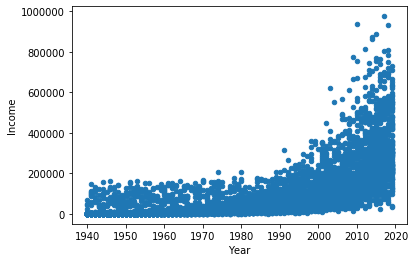

In [8]:
########################################### Start with Year
# use 1% sample to plot
total_df[:t_row].sample(frac = 0.01, random_state = None).plot.scatter(x='Year', y = 'Income')

In [9]:
# devide into 2 columns according to the 1990 boundary
total_df['Year B1990'] = total_df['Year'].map(lambda y: y if y <= 1990 else 0)
total_df['Year A1990'] = total_df['Year'].map(lambda y: y if y > 1990 else 0)

total_df.head()

,Year,Housing,Crime,WorkExp,Satisfation,Gender,Age,Country,SoC,Profession,UD,Glasses,Hair Color,Height,AddIn,Income,Year B1990,Year A1990
Instance,,,,,,,,,,,,,,,,,,
1,1940.0,0,33,17,Unhappy,other,45,Afghanistan,25179,group head,No,1,Black,182,0 EUR,6182.05,1940.0,0.0
2,1940.0,0,25,4.9,Unhappy,female,17,Afghanistan,2278204,heavy vehicle and mobile equipment service tec...,No,0,Blond,172,0 EUR,6819.69,1940.0,0.0
3,1940.0,0,34,21,Unhappy,female,48,Afghanistan,822134,sorter,Bachelor,0,Blond,144,0 EUR,8663.53,1940.0,0.0
4,1940.0,0,70,18,Average,female,42,Albania,59477,quality control senior engineer,No,1,Brown,152,0 EUR,2400.64,1940.0,0.0
5,1940.0,0,51,8,Happy,other,15,Albania,23494,logistician,Master,1,Black,180,0 EUR,2816.18,1940.0,0.0


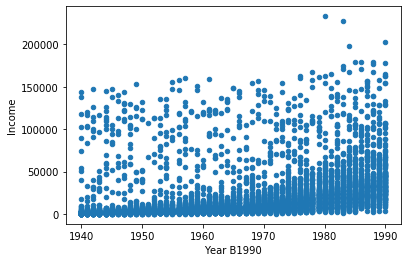

In [10]:
total_df[(total_df['Year B1990'] != 0) & (total_df['Income'] != 0)].sample(frac = 0.01, random_state = None).plot.scatter(x = 'Year B1990', y = 'Income')

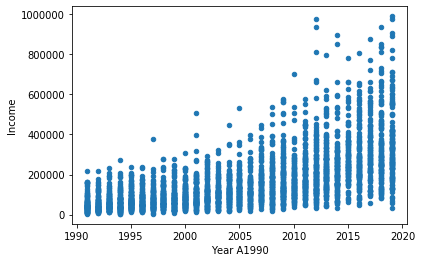

In [11]:
total_df[(total_df['Year A1990'] != 0) & (total_df['Income'] != 0)].sample(frac = 0.01, random_state = None).plot.scatter(x = 'Year A1990', y = 'Income')

In [12]:
# 50 ^ 3 * 0.8 = 100,000
# 80 ^ 3 * 0.8 = 409,600
# do a pow of 3 on year

total_df['Year Resized'] = total_df['Year'].map(lambda y: (y-1939) ** 3)

total_df.head()
########################################### Done with Year

,Year,Housing,Crime,WorkExp,Satisfation,Gender,Age,Country,SoC,Profession,UD,Glasses,Hair Color,Height,AddIn,Income,Year B1990,Year A1990,Year Resized
Instance,,,,,,,,,,,,,,,,,,,
1,1940.0,0,33,17,Unhappy,other,45,Afghanistan,25179,group head,No,1,Black,182,0 EUR,6182.05,1940.0,0.0,1.0
2,1940.0,0,25,4.9,Unhappy,female,17,Afghanistan,2278204,heavy vehicle and mobile equipment service tec...,No,0,Blond,172,0 EUR,6819.69,1940.0,0.0,1.0
3,1940.0,0,34,21,Unhappy,female,48,Afghanistan,822134,sorter,Bachelor,0,Blond,144,0 EUR,8663.53,1940.0,0.0,1.0
4,1940.0,0,70,18,Average,female,42,Albania,59477,quality control senior engineer,No,1,Brown,152,0 EUR,2400.64,1940.0,0.0,1.0
5,1940.0,0,51,8,Happy,other,15,Albania,23494,logistician,Master,1,Black,180,0 EUR,2816.18,1940.0,0.0,1.0


In [13]:
########################################### Start with Housing

# count
total_df['Housing'].value_counts().sort_index()

0                   181098
Castle              157883
Large Apartment     157986
Large House         157359
Medium Apartment    124117
Medium House        157792
Small Apartment       9419
Small House         157964
nA                  157253
Name: Housing, dtype: int64

In [14]:
# Housing - one hot encoding and repale the original column with frequency

# TODO: deal with na and 0 values

dummies = pd.get_dummies(total_df['Housing'], prefix = 'HS')

total_df = total_df.join(dummies)
fq_encode = total_df['Housing'].value_counts(normalize=True).to_dict()
total_df['Housing_F'] = total_df['Housing'].map(fq_encode)
total_df.drop('Housing', axis = 1, inplace = True)

total_df.head()
########################################### Done with Housing

,Year,Crime,WorkExp,Satisfation,Gender,Age,Country,SoC,Profession,UD,...,HS_0,HS_Castle,HS_Large Apartment,HS_Large House,HS_Medium Apartment,HS_Medium House,HS_Small Apartment,HS_Small House,HS_nA,Housing_F
Instance,,,,,,,,,,,,,,,,,,,,,
1,1940.0,33,17,Unhappy,other,45,Afghanistan,25179,group head,No,...,1,0,0,0,0,0,0,0,0,0.185174
1,1940.0,33,17,Unhappy,other,45,Afghanistan,25179,group head,No,...,0,0,0,0,0,0,0,1,0,0.185174
1,1994.0,23,12,Average,other,23,Serbia,734369,quality assurance specialist,Bachelor,...,1,0,0,0,0,0,0,0,0,0.103522
1,1994.0,23,12,Average,other,23,Serbia,734369,quality assurance specialist,Bachelor,...,0,0,0,0,0,0,0,1,0,0.103522
2,1940.0,25,4.9,Unhappy,female,17,Afghanistan,2278204,heavy vehicle and mobile equipment service tec...,No,...,1,0,0,0,0,0,0,0,0,0.185174


In [15]:
########################################### Start with Crime
# count
total_df['Crime'].value_counts().sort_index()

0      63412
4      13085
5      31728
6      17999
7        149
       ...  
197       28
198       30
199       17
200        4
204        2
Name: Crime, Length: 199, dtype: int64

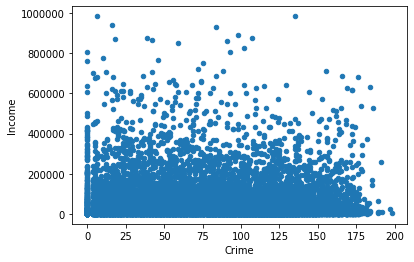

In [16]:
total_df[(total_df['Income'] != 0)].sample(frac = 0.01, random_state = None).plot.scatter(x='Crime', y = 'Income')

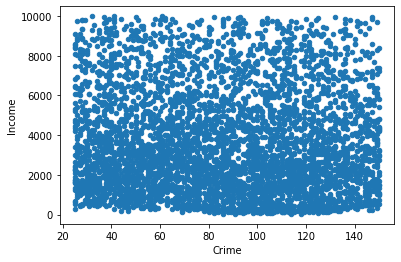

In [17]:
total_df[(total_df['Income'] < 10000) & (total_df['Income'] != 0) & (total_df['Crime'] >= 25) & (total_df['Crime'] <= 150)].sample(frac = 0.01, random_state = None).plot.scatter(x='Crime', y = 'Income')

In [18]:
# frewuency encode
fq_encode = total_df['Crime'].value_counts(normalize=True).to_dict()
total_df['Crime_F'] = total_df['Crime'].map(fq_encode)
total_df.drop('Crime', axis = 1, inplace = True)

total_df.columns
########################################### Done with Crime

Index(['Year', 'WorkExp', 'Satisfation', 'Gender', 'Age', 'Country', 'SoC',
       'Profession', 'UD', 'Glasses', 'Hair Color', 'Height', 'AddIn',
       'Income', 'Year B1990', 'Year A1990', 'Year Resized', 'HS_0',
       'HS_Castle', 'HS_Large Apartment', 'HS_Large House',
       'HS_Medium Apartment', 'HS_Medium House', 'HS_Small Apartment',
       'HS_Small House', 'HS_nA', 'Housing_F', 'Crime_F'],
      dtype='object')

In [19]:
########################################### Start with WorkExp
# count
total_df['WorkExp'].value_counts().sort_index()

# 'fillna'
total_df['WorkExp'] = total_df['WorkExp'].map(lambda we: 0 if we == '#NUM!' else we)

# dtype to float
total_df['WorkExp'] = total_df['WorkExp'].astype('float64')

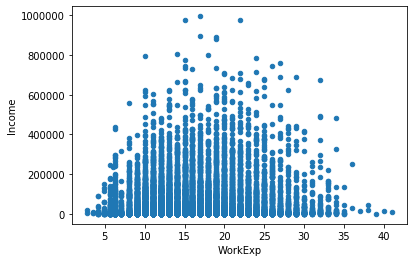

In [20]:
total_df[(total_df['Income'] != 0)].sample(frac = 0.01, random_state = None).plot.scatter(x='WorkExp', y = 'Income')

In [21]:
# count
total_df['WorkExp'].value_counts().sort_index()

0.0         30
0.7          2
1.4          7
2.0         11
2.1         29
2.8         89
3.0         55
3.5        366
4.0        214
4.2       1588
4.9       5531
5.0        836
5.6      13783
6.0       3783
6.3      24621
7.0      13049
8.0      35226
9.0      68378
10.0    125931
11.0    137575
12.0    138642
13.0    136541
14.0    133979
15.0    130432
16.0    124912
17.0    118029
18.0    109525
19.0    100753
20.0     90710
21.0     79680
22.0     68905
23.0     58126
24.0     48553
25.0     39134
26.0     31540
27.0     24119
28.0     18536
29.0     13867
30.0     10077
31.0      7182
32.0      5127
33.0      3466
34.0      2307
35.0      1434
36.0      1017
37.0       589
38.0       349
39.0       181
40.0       136
41.0        51
42.0        14
43.0         4
44.0         4
45.0         8
47.0         2
Name: WorkExp, dtype: int64

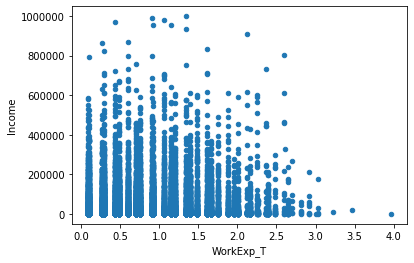

In [22]:
# before powertransform make it strictly possitive
total_df['WorkExp'] = total_df['WorkExp'].map(lambda we: we + 0.00001)

# perform powertransform
PT = PowerTransformer(method='box-cox', standardize=True)
total_df['WorkExp_T'] = PT.fit_transform(total_df[['WorkExp']])

# perform a inverse
total_df['WorkExp_T'] = total_df['WorkExp_T'].map(lambda wet: np.abs(wet))

total_df[(total_df['Income'] != 0)].sample(frac = 0.01, random_state = None).plot.scatter(x='WorkExp_T', y = 'Income')

In [23]:
total_df.columns
########################################### Done with WorkExp

Index(['Year', 'WorkExp', 'Satisfation', 'Gender', 'Age', 'Country', 'SoC',
       'Profession', 'UD', 'Glasses', 'Hair Color', 'Height', 'AddIn',
       'Income', 'Year B1990', 'Year A1990', 'Year Resized', 'HS_0',
       'HS_Castle', 'HS_Large Apartment', 'HS_Large House',
       'HS_Medium Apartment', 'HS_Medium House', 'HS_Small Apartment',
       'HS_Small House', 'HS_nA', 'Housing_F', 'Crime_F', 'WorkExp_T'],
      dtype='object')

In [24]:
########################################### Start with Satisfation
# count
total_df['Satisfation'].value_counts().sort_index()

Average           893879
Happy             647955
Somewhat Happy    285976
Unhappy            31406
Name: Satisfation, dtype: int64

In [25]:
dummies = pd.get_dummies(total_df['Satisfation'], prefix = 'Satis')
total_df = total_df.join(dummies)

fq_encode = total_df['Satisfation'].value_counts(normalize=True).to_dict()
total_df['Satisfation_F'] = total_df['Satisfation'].map(fq_encode)

total_df.drop('Satisfation', axis = 1, inplace = True)

total_df.columns
########################################### Done with Satisfation

Index(['Year', 'WorkExp', 'Gender', 'Age', 'Country', 'SoC', 'Profession',
       'UD', 'Glasses', 'Hair Color', 'Height', 'AddIn', 'Income',
       'Year B1990', 'Year A1990', 'Year Resized', 'HS_0', 'HS_Castle',
       'HS_Large Apartment', 'HS_Large House', 'HS_Medium Apartment',
       'HS_Medium House', 'HS_Small Apartment', 'HS_Small House', 'HS_nA',
       'Housing_F', 'Crime_F', 'WorkExp_T', 'Satis_Average', 'Satis_Happy',
       'Satis_Somewhat Happy', 'Satis_Unhappy', 'Satisfation_F'],
      dtype='object')

In [26]:
########################################### Start with Gender
# count
total_df['Gender'].value_counts().sort_index()

0            17115
f            53245
female     1380900
male       2278413
other      1432855
unknown     362825
Name: Gender, dtype: int64

In [27]:
# frequency encoding
fq_encode = total_df['Gender'].value_counts(normalize=True).to_dict()
total_df['Gender_F'] = total_df['Gender'].map(fq_encode)

# # f => female
# total_df['Gender'] = total_df['Gender'].map(lambda g: 'female' if g == 'f' else g)

# # 0 => unknown
# total_df['Gender'] = total_df['Gender'].map(lambda g: 'unknown' if g == '0' else g)

# TODO: unknown values 

# one hot encoding
dummies = pd.get_dummies(total_df['Gender'], prefix = 'G')
total_df = total_df.join(dummies)

total_df.drop('Gender', axis = 1, inplace = True)

total_df.columns
########################################### Done with Gender

Index(['Year', 'WorkExp', 'Age', 'Country', 'SoC', 'Profession', 'UD',
       'Glasses', 'Hair Color', 'Height', 'AddIn', 'Income', 'Year B1990',
       'Year A1990', 'Year Resized', 'HS_0', 'HS_Castle', 'HS_Large Apartment',
       'HS_Large House', 'HS_Medium Apartment', 'HS_Medium House',
       'HS_Small Apartment', 'HS_Small House', 'HS_nA', 'Housing_F', 'Crime_F',
       'WorkExp_T', 'Satis_Average', 'Satis_Happy', 'Satis_Somewhat Happy',
       'Satis_Unhappy', 'Satisfation_F', 'Gender_F', 'G_0', 'G_f', 'G_female',
       'G_male', 'G_other', 'G_unknown'],
      dtype='object')

In [28]:
########################################### Start with Age
# count
total_df['Age'].value_counts().sort_index()

14     1039199
15     2093465
16     2049609
17     2073974
18     2079979
        ...   
117        128
118        128
119        128
121        128
126        128
Name: Age, Length: 107, dtype: int64

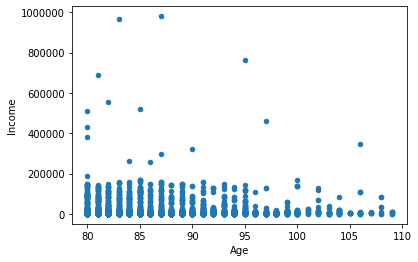

In [29]:
total_df[(total_df['Income'] != 0) & (total_df['Age'] >= 80) & (total_df['Age'] < 110)].sample(frac = 0.01, random_state = None).plot.scatter(x='Age', y = 'Income')

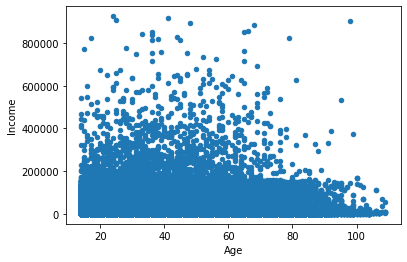

In [30]:
# divide
total_df[(total_df['Income'] != 0)].sample(frac = 0.01, random_state = None).plot.scatter(x='Age', y = 'Income')

In [31]:
total_df.columns
########################################### Done with Age

Index(['Year', 'WorkExp', 'Age', 'Country', 'SoC', 'Profession', 'UD',
       'Glasses', 'Hair Color', 'Height', 'AddIn', 'Income', 'Year B1990',
       'Year A1990', 'Year Resized', 'HS_0', 'HS_Castle', 'HS_Large Apartment',
       'HS_Large House', 'HS_Medium Apartment', 'HS_Medium House',
       'HS_Small Apartment', 'HS_Small House', 'HS_nA', 'Housing_F', 'Crime_F',
       'WorkExp_T', 'Satis_Average', 'Satis_Happy', 'Satis_Somewhat Happy',
       'Satis_Unhappy', 'Satisfation_F', 'Gender_F', 'G_0', 'G_f', 'G_female',
       'G_male', 'G_other', 'G_unknown'],
      dtype='object')

In [32]:
########################################### Start with Gender
# count
total_df['Country'].value_counts().sort_index()

Afghanistan             14522
Albania                319835
Algeria                  7340
Angola                  40979
Antigua and Barbuda       128
                        ...  
Venezuela               34971
Vietnam                   128
Yemen                   28575
Zambia                 167418
Zimbabwe               338860
Name: Country, Length: 181, dtype: int64

In [ ]:
# freq encoding
fq_encode = total_df['Country'].value_counts(normalize=True).to_dict()
total_df['Country_F'] = total_df['Country'].map(fq_encode)

# one hot encoding
dummies = pd.get_dummies(total_df['Country'], prefix = 'CTR')
total_df = total_df.join(dummies)

# drop the original column
total_df.drop('Country', axis = 1, inplace = True)

total_df.columns

########################################### End with Country

In [ ]:
########################################### Start with SoC
# value counts
total_df['SoC'].value_counts().sort_index()